# **GPU 설정**

In [ ]:
import tensorflow as tf

# GPU 디바이스 확인
tf.test.gpu_device_name()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# TensorFlow가 GPU를 사용할 수 있도록 설정합니다.
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU is enabled')
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)


Num GPUs Available:  1
GPU is enabled


# **데이터 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import cv2
import numpy as np

In [ ]:
dataset_path = '/content/drive/MyDrive/ColabNotebooks/프로젝트/FaceClassifier/data/fer2013.csv'
image_size=(48,48)

def load_fer2013():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist()

    width, height = 48,48
    faces = []

    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))

    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion'])
    emotions = emotions.to_numpy()
    return faces, emotions

dataset_path2 = '/content/drive/MyDrive/ColabNotebooks/프로젝트/FaceClassifier/data/test.csv'
image_size=(48,48)

def load_test():
    data = pd.read_csv(dataset_path2)
    pixels = data['pixels'].tolist()

    width, height = 48,48
    faces = []

    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))

    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion'])
    emotions = emotions.to_numpy()
    return faces, emotions


def preprocess_input(x):
    x = x.astype('float32')
    x = x / 255.

    return x

In [ ]:
X_train, y_train = load_fer2013()
X_train = X_train / 255.

from sklearn.model_selection import train_test_split

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


print(X_train[:3])
print(y_train[:3])

[[[[0.4509804 ]
   [0.50980395]
   [0.5686275 ]
   ...
   [0.01176471]
   [0.01176471]
   [0.01176471]]

  [[0.43529412]
   [0.48235294]
   [0.54901963]
   ...
   [0.00784314]
   [0.00784314]
   [0.01176471]]

  [[0.44313726]
   [0.46666667]
   [0.48235294]
   ...
   [0.00784314]
   [0.00784314]
   [0.00784314]]

  ...

  [[0.        ]
   [0.06666667]
   [0.09411765]
   ...
   [0.3529412 ]
   [0.10588235]
   [0.05098039]]

  [[0.        ]
   [0.03921569]
   [0.10196079]
   ...
   [0.29803923]
   [0.05490196]
   [0.02352941]]

  [[0.        ]
   [0.01568628]
   [0.09803922]
   ...
   [0.16862746]
   [0.03529412]
   [0.        ]]]


 [[[0.07450981]
   [0.03137255]
   [0.01960784]
   ...
   [0.38431373]
   [0.41568628]
   [0.43137255]]

  [[0.06666667]
   [0.03137255]
   [0.01568628]
   ...
   [0.45490196]
   [0.5254902 ]
   [0.49411765]]

  [[0.05490196]
   [0.02745098]
   [0.01568628]
   ...
   [0.5647059 ]
   [0.5568628 ]
   [0.59607846]]

  ...

  [[0.01176471]
   [0.01568628]
   [0.0

# **데이터 전처리**

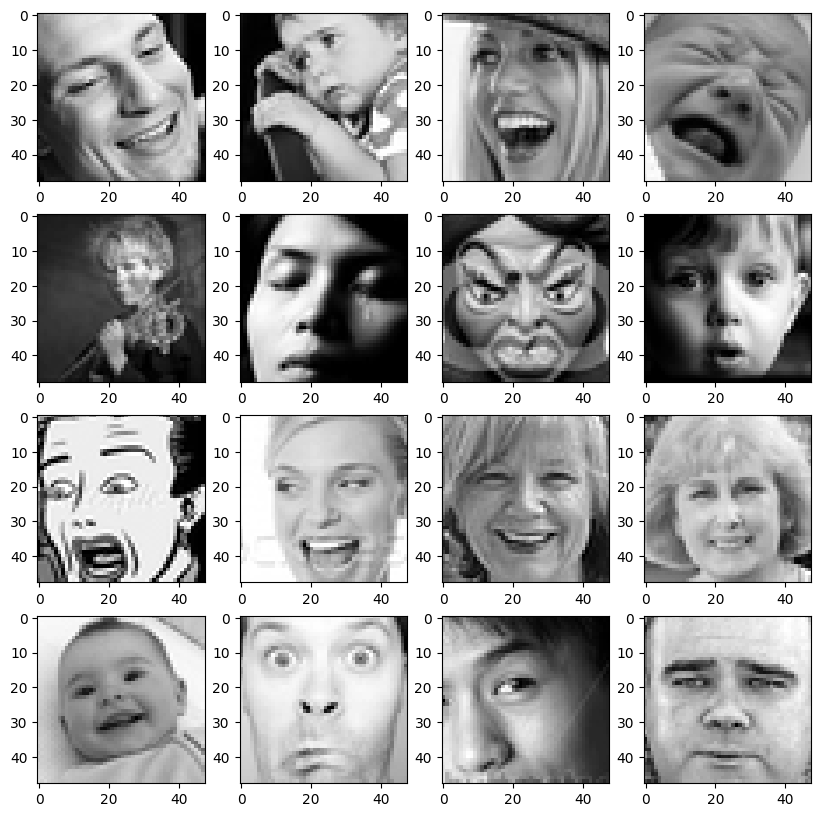

In [ ]:
# Data check
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for c in range(16):
	plt.subplot(4,4,c+1)
	plt.imshow(X_train[c].reshape(48,48),cmap='gray')
plt.show()

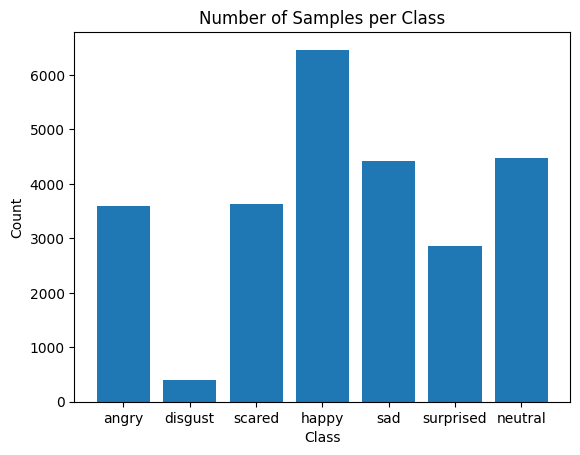

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 각 클래스 당 개수 계산
counts = np.sum(y_train, axis=0)

# 그래프 그리기
plt.bar(range(len(counts)), counts)
plt.xticks(range(len(counts)), ["angry" ,"disgust","scared", "happy", "sad", "surprised", "neutral"])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Samples per Class')
plt.show()

# **모델 구성**

In [ ]:
def simple_CNN(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (7, 7), padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(16, (7, 7), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Dropout(.5),

        tf.keras.layers.Conv2D(32, (5, 5), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, (5, 5), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Dropout(.5),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Dropout(.5),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Dropout(.5),

        tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(num_classes, (3, 3), padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Activation('softmax')
    ])
    return model


In [ ]:
def deeper_CNN(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(.25),
        
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(.25),
        
        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(.25),
        
        tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(.25),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.5),
        
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
def deeperer_CNN(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (2, 2), padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(32, (2, 2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(.25),

        tf.keras.layers.Conv2D(64, (2, 2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(64, (2, 2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(.25),

        tf.keras.layers.Conv2D(128, (2, 2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(128, (2, 2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(.25),

        tf.keras.layers.Conv2D(256, (2, 2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(256, (2, 2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(.25),

        tf.keras.layers.Conv2D(512, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(512, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.5),

        tf.keras.layers.Dense(512),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.5),

        tf.keras.layers.Dense(256),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.5),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
import tensorflow as tf
from tensorflow import keras

def transfer_model(input_shape, num_classes):
    # VGG16 모델 불러오기 (include_top=False: fully connected layer 제외)
    vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # 일부 레이어 동결 해제
    for layer in vgg16.layers[:-4]:
        layer.trainable = False
    
    # 모델 정의
    model = tf.keras.models.Sequential()
    model.add(vgg16)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    return model


In [ ]:
model = deeper_CNN((48,48,1), 7)

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

early_stop = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_21 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_22 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 activation_22 (Activation)  (None, 48, 48, 32)       

In [ ]:
history = model.fit(X_train, y_train, epochs=40, batch_size=16, callbacks=[early_stop], validation_data=(X_val, y_val))

Epoch 1/40
1615/1615 [==============================] - 29s 13ms/step - loss: 2.1277 - accuracy: 0.2305 - val_loss: 1.7169 - val_accuracy: 0.3125
Epoch 2/40
1615/1615 [==============================] - 24s 15ms/step - loss: 1.8681 - accuracy: 0.3008 - val_loss: 1.5803 - val_accuracy: 0.4034
Epoch 3/40
1615/1615 [==============================] - 20s 12ms/step - loss: 1.7041 - accuracy: 0.3599 - val_loss: 1.4379 - val_accuracy: 0.4450
Epoch 4/40
1615/1615 [==============================] - 22s 14ms/step - loss: 1.5607 - accuracy: 0.4095 - val_loss: 1.3532 - val_accuracy: 0.4779
Epoch 5/40
1615/1615 [==============================] - 21s 13ms/step - loss: 1.4616 - accuracy: 0.4459 - val_loss: 1.2933 - val_accuracy: 0.5111
Epoch 6/40
1615/1615 [==============================] - 23s 14ms/step - loss: 1.3779 - accuracy: 0.4766 - val_loss: 1.2460 - val_accuracy: 0.5161
Epoch 7/40
1615/1615 [==============================] - 22s 14ms/step - loss: 1.3112 - accuracy: 0.5005 - val_loss: 1.1988 -

In [ ]:
print(model.metrics_names)

['loss', 'accuracy']


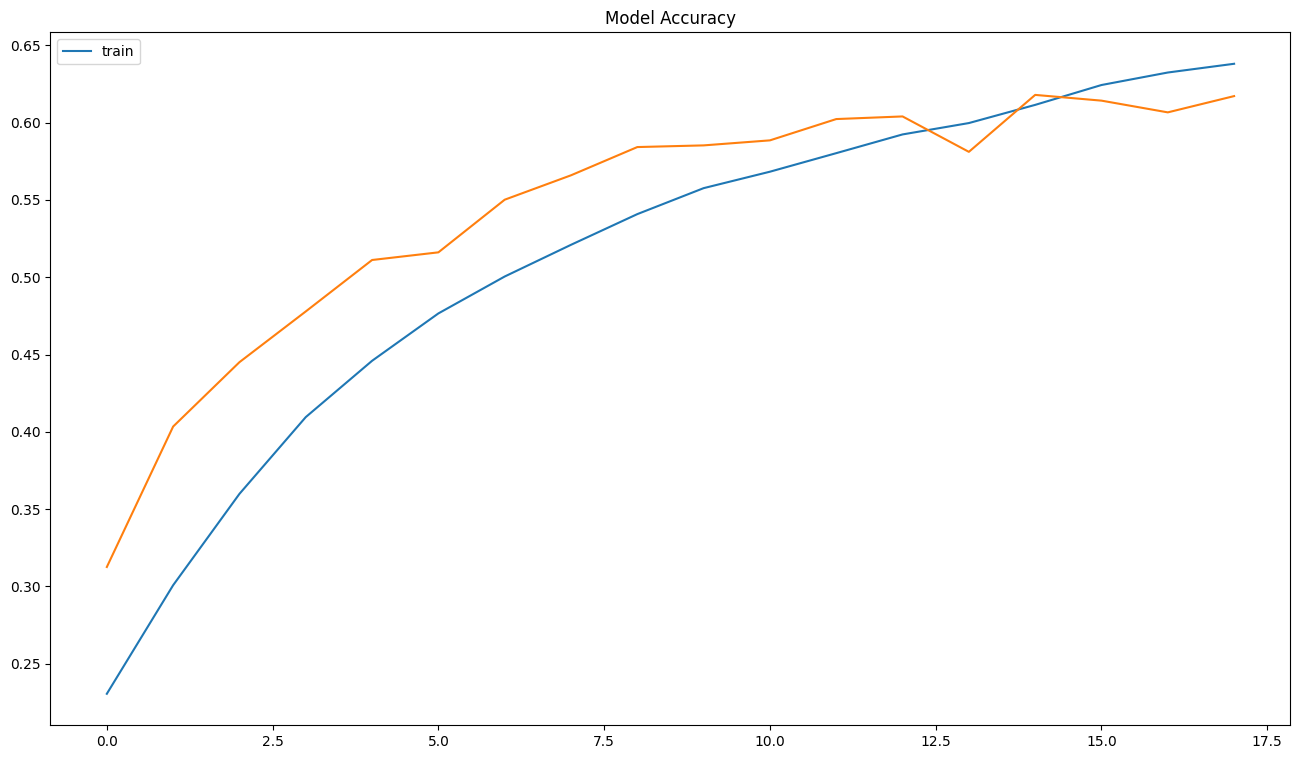

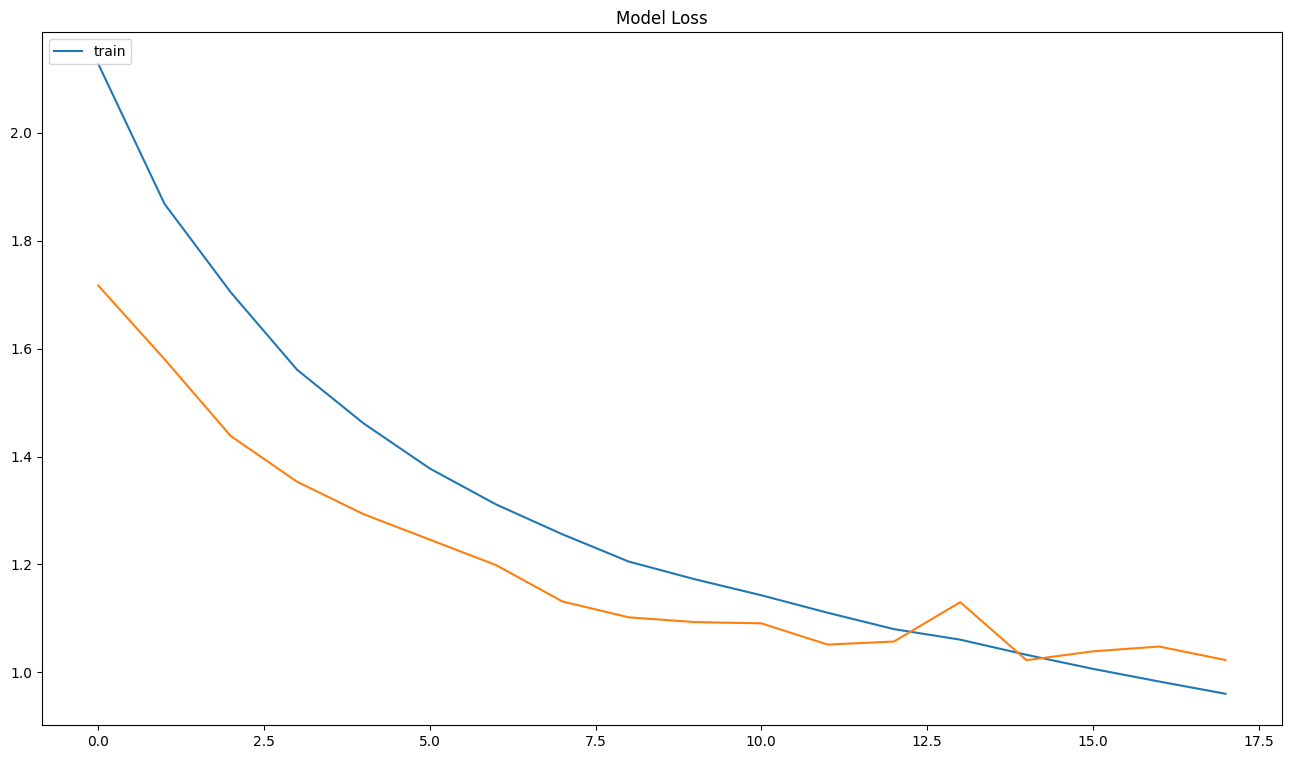

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/face1(2023-05-02).h5')

In [ ]:
model.evaluate(X_test, y_test)

113/113 [==============================] - 1s 8ms/step - loss: 1.0416 - accuracy: 0.6144


[1.041622281074524, 0.6143772602081299]

113/113 [==============================] - 1s 5ms/step


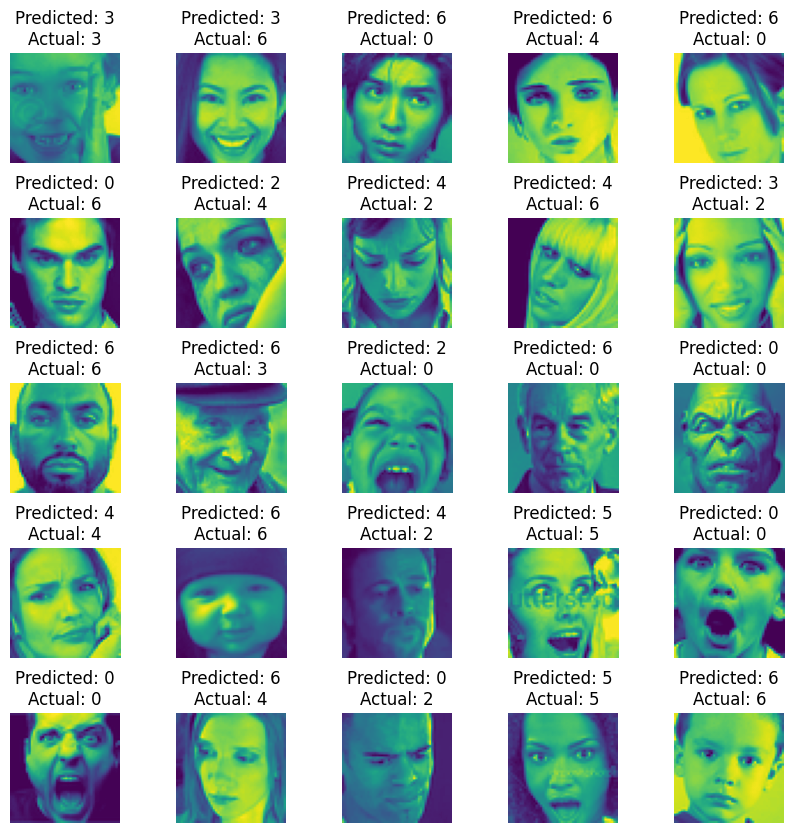

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(25):
    # 이미지 출력
    axs[i//5, i%5].imshow(X_test[i])
    axs[i//5, i%5].axis('off')
    
    # 예측한 클래스와 실제 클래스 출력
    predicted_label = np.argmax(y_pred[i])
    actual_label = np.argmax(y_test[i])
    axs[i//5, i%5].set_title(f"Predicted: {predicted_label}\nActual: {actual_label}")
    
plt.show()